In [1]:
import os
from pathlib import Path

import h5py
import numpy as np
import matplotlib.pyplot as plt

# where to store the sample
OUT_DIR = Path("./libero_sample")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("OUT_DIR:", OUT_DIR.resolve())

OUT_DIR: /ibex/project/c2320/dataset-check/libero/libero_sample


In [5]:
from pathlib import Path
import h5py

SAMPLE = Path("/ibex/project/c2320/dataset-check/huggingface/datasets/libero_spatial/pick_up_the_black_bowl_between_the_plate_and_the_ramekin_and_place_it_on_the_plate_demo.hdf5")

with h5py.File(SAMPLE, "r") as f:
    print("Top-level keys:", list(f.keys()))
    demos = list(f["data"].keys())
    print("Number of demos:", len(demos))


Top-level keys: ['data']
Number of demos: 50


In [7]:
demo_id = demos[0]

with h5py.File(SAMPLE, "r") as f:
    demo = f["data"][demo_id]

    print("Demo keys:", list(demo.keys()))

    obs = demo["obs"]
    print("\nObservation keys:")
    for k in obs:
        print(f"  {k:20s} shape={obs[k].shape} dtype={obs[k].dtype}")

    if "actions" in demo:
        print("\nActions:", demo["actions"].shape, demo["actions"].dtype)


Demo keys: ['actions', 'dones', 'obs', 'rewards', 'robot_states', 'states']

Observation keys:
  agentview_rgb        shape=(98, 128, 128, 3) dtype=uint8
  ee_ori               shape=(98, 3) dtype=float64
  ee_pos               shape=(98, 3) dtype=float64
  ee_states            shape=(98, 6) dtype=float64
  eye_in_hand_rgb      shape=(98, 128, 128, 3) dtype=uint8
  gripper_states       shape=(98, 2) dtype=float64
  joint_states         shape=(98, 7) dtype=float64

Actions: (98, 7) float64


In [8]:
lengths = []

with h5py.File(SAMPLE, "r") as f:
    for d in f["data"].values():
        lengths.append(d["actions"].shape[0])

print("Min length:", min(lengths))
print("Max length:", max(lengths))
print("Unique lengths:", sorted(set(lengths))[:10])


Min length: 75
Max length: 168
Unique lengths: [75, 79, 84, 85, 86, 87, 88, 89, 90, 91]


In [9]:
with h5py.File(SAMPLE, "r") as f:
    if "meta" in f and "language_instructions" in f["meta"]:
        lang = f["meta"]["language_instructions"][()]
        if isinstance(lang, (bytes, bytearray)):
            lang = lang.decode()
        print("Language instruction:", lang)
    else:
        print("No meta language key found (instruction inferred from task name)")


No meta language key found (instruction inferred from task name)


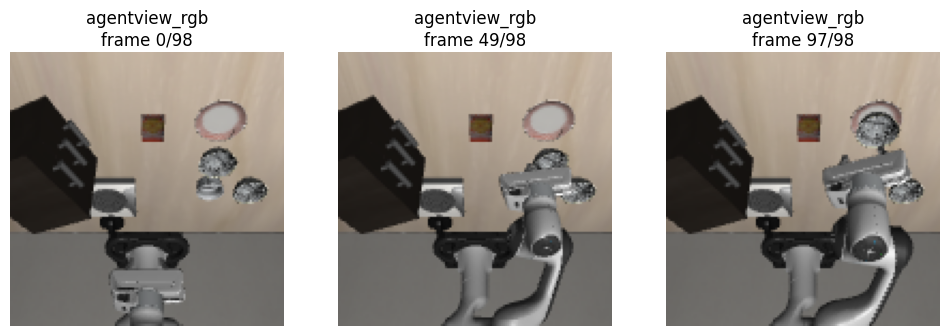

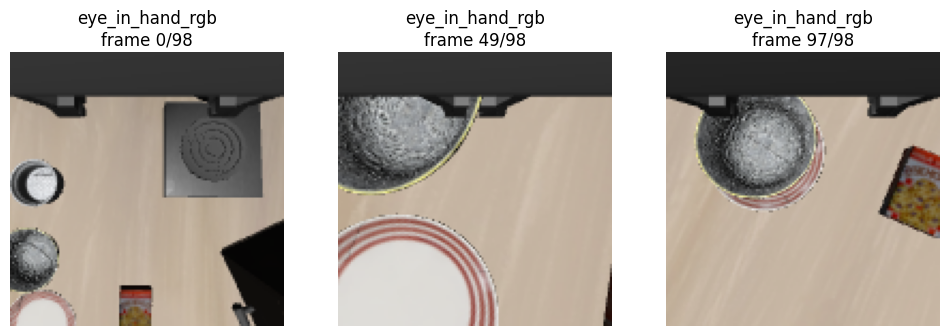

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def show_frames(rgb, title, frames=(0, None, -1)):
    T = rgb.shape[0]
    idxs = []
    for f in frames:
        if f is None:
            idxs.append(T // 2)
        elif f < 0:
            idxs.append(T + f)
        else:
            idxs.append(f)

    plt.figure(figsize=(4 * len(idxs), 4))
    for i, t in enumerate(idxs):
        plt.subplot(1, len(idxs), i + 1)
        plt.imshow(rgb[t])
        plt.axis("off")
        plt.title(f"{title}\nframe {t}/{T}")
    plt.show()


with h5py.File(SAMPLE, "r") as f:
    demo = f["data"][demos[0]]
    obs = demo["obs"]

    if "agentview_rgb" in obs:
        show_frames(np.array(obs["agentview_rgb"]), "agentview_rgb")

    if "eye_in_hand_rgb" in obs:
        show_frames(np.array(obs["eye_in_hand_rgb"]), "eye_in_hand_rgb")


In [16]:
from pathlib import Path
import math, random
import h5py
import numpy as np
import matplotlib.pyplot as plt

SUITE_DIR = Path("/ibex/project/c2320/dataset-check/huggingface/datasets/libero_spatial")
assert SUITE_DIR.exists(), f"Suite dir not found: {SUITE_DIR}"

task_files = sorted(SUITE_DIR.glob("*.hdf5"))
print("Suite:", SUITE_DIR.name)
print("Num task files:", len(task_files))
print("First 3 tasks:", [p.name for p in task_files[:3]])


Suite: libero_spatial
Num task files: 10
First 3 tasks: ['pick_up_the_black_bowl_between_the_plate_and_the_ramekin_and_place_it_on_the_plate_demo.hdf5', 'pick_up_the_black_bowl_from_table_center_and_place_it_on_the_plate_demo.hdf5', 'pick_up_the_black_bowl_in_the_top_drawer_of_the_wooden_cabinet_and_place_it_on_the_plate_demo.hdf5']


In [17]:
def count_demos_in_task(h5_path: Path) -> int:
    with h5py.File(h5_path, "r") as f:
        return len(f["data"].keys())

demo_counts = []
for p in task_files:
    try:
        demo_counts.append(count_demos_in_task(p))
    except Exception as e:
        demo_counts.append(0)
        print("failed reading", p.name, "->", e)

total_records = sum(demo_counts)
print("Total records (demos) in suite:", total_records)
print("Per-task demos (min/median/max):",
      min(demo_counts), int(np.median(demo_counts)), max(demo_counts))


Total records (demos) in suite: 500
Per-task demos (min/median/max): 50 50 50


In [18]:
def sampling_fraction(N: int) -> float:
    # 1% sample for ≤10,000 records
    # 0.1% for ≤100,000
    # 0.01% for ≤1,000,000
    # 0.001% for ≤10,000,000
    if N <= 10_000:
        return 0.01
    if N <= 100_000:
        return 0.001
    if N <= 1_000_000:
        return 0.0001
    if N <= 10_000_000:
        return 0.00001
    # beyond that, keep the smallest rate (or adjust later)
    return 0.00001

frac = sampling_fraction(total_records)
target_records = max(1, math.ceil(total_records * frac))

print("Sampling fraction:", frac)
print("Target sample records:", target_records)


Sampling fraction: 0.01
Target sample records: 5


In [19]:
random.seed(42)

num_tasks_to_sample = min(len(task_files), target_records)
sampled_tasks = random.sample(task_files, num_tasks_to_sample)

print("Sampled tasks:", len(sampled_tasks))
print("Example sampled task names:", [p.name for p in sampled_tasks[:5]])


Sampled tasks: 5
Example sampled task names: ['pick_up_the_black_bowl_from_table_center_and_place_it_on_the_plate_demo.hdf5', 'pick_up_the_black_bowl_between_the_plate_and_the_ramekin_and_place_it_on_the_plate_demo.hdf5', 'pick_up_the_black_bowl_next_to_the_plate_and_place_it_on_the_plate_demo.hdf5', 'pick_up_the_black_bowl_on_the_wooden_cabinet_and_place_it_on_the_plate_demo.hdf5', 'pick_up_the_black_bowl_on_the_cookie_box_and_place_it_on_the_plate_demo.hdf5']


In [20]:
def pick_one_demo(h5_path: Path) -> str:
    with h5py.File(h5_path, "r") as f:
        demos = list(f["data"].keys())
    return random.choice(demos)

samples = []  # list of (task_file, demo_id)
for p in sampled_tasks:
    try:
        demo_id = pick_one_demo(p)
        samples.append((p, demo_id))
    except Exception as e:
        print("failed sampling demo from", p.name, "->", e)

print("Total sampled records:", len(samples))
print("First 5 samples:")
for p, d in samples[:5]:
    print(" -", p.name, "::", d)


Total sampled records: 5
First 5 samples:
 - pick_up_the_black_bowl_from_table_center_and_place_it_on_the_plate_demo.hdf5 :: demo_16
 - pick_up_the_black_bowl_between_the_plate_and_the_ramekin_and_place_it_on_the_plate_demo.hdf5 :: demo_7
 - pick_up_the_black_bowl_next_to_the_plate_and_place_it_on_the_plate_demo.hdf5 :: demo_14
 - pick_up_the_black_bowl_on_the_wooden_cabinet_and_place_it_on_the_plate_demo.hdf5 :: demo_48
 - pick_up_the_black_bowl_on_the_cookie_box_and_place_it_on_the_plate_demo.hdf5 :: demo_7


pick_up_the_black_bowl_from_table_center_and_place_it_on_the_plate_demo.hdf5
demo: demo_16
  - agentview_rgb: shape=(105, 128, 128, 3) dtype=uint8


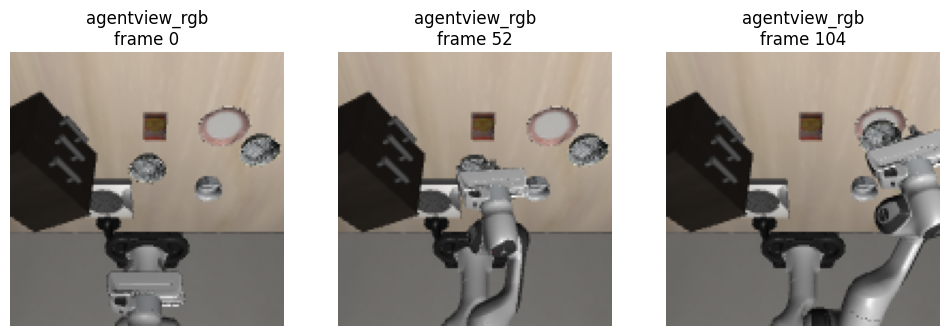

  - eye_in_hand_rgb: shape=(105, 128, 128, 3) dtype=uint8


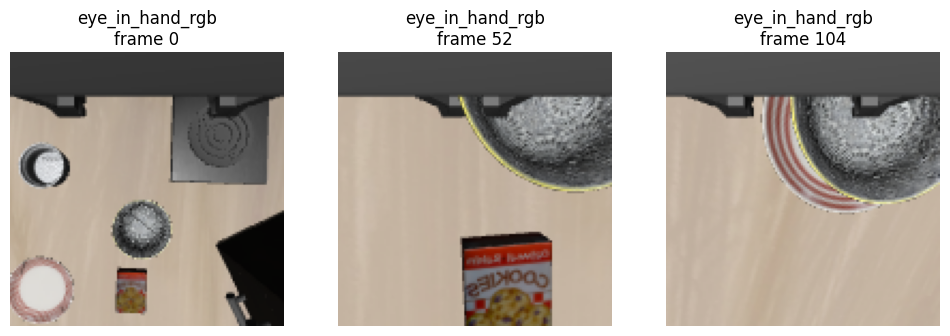

pick_up_the_black_bowl_between_the_plate_and_the_ramekin_and_place_it_on_the_plate_demo.hdf5
demo: demo_7
  - agentview_rgb: shape=(92, 128, 128, 3) dtype=uint8


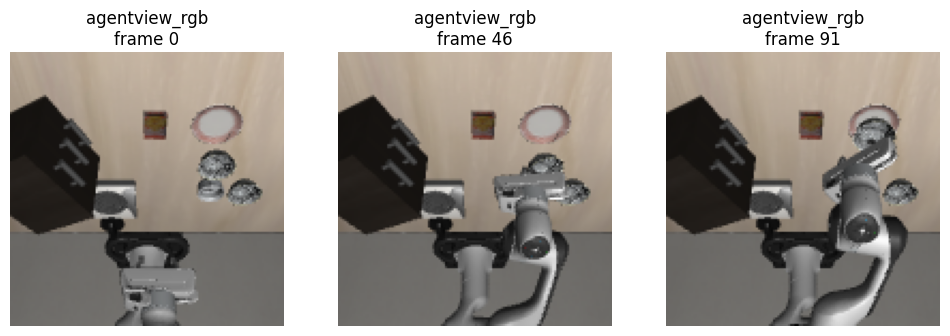

  - eye_in_hand_rgb: shape=(92, 128, 128, 3) dtype=uint8


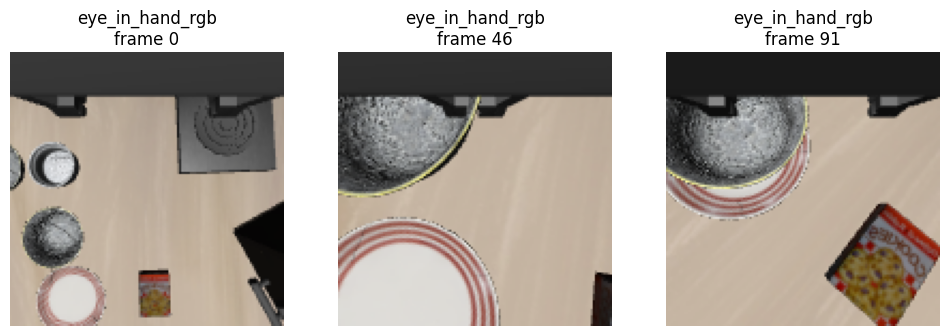

pick_up_the_black_bowl_next_to_the_plate_and_place_it_on_the_plate_demo.hdf5
demo: demo_14
  - agentview_rgb: shape=(97, 128, 128, 3) dtype=uint8


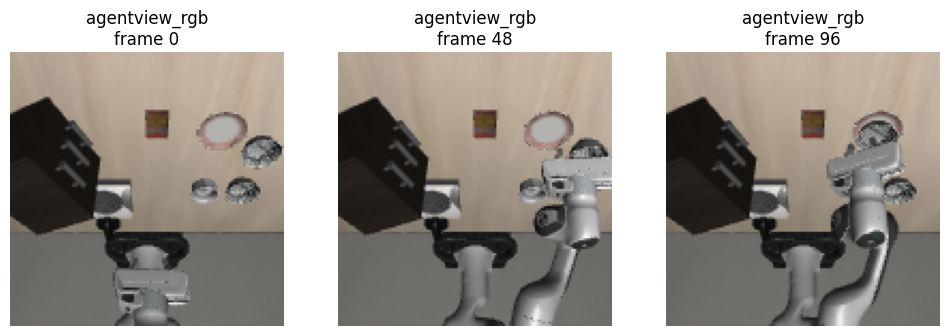

  - eye_in_hand_rgb: shape=(97, 128, 128, 3) dtype=uint8


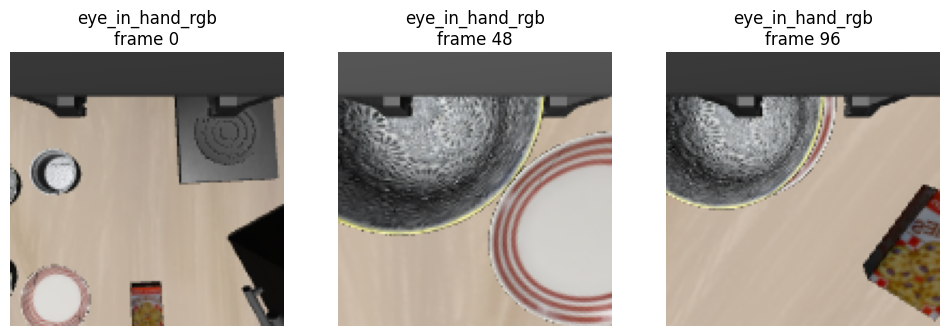

pick_up_the_black_bowl_on_the_wooden_cabinet_and_place_it_on_the_plate_demo.hdf5
demo: demo_48
  - agentview_rgb: shape=(117, 128, 128, 3) dtype=uint8


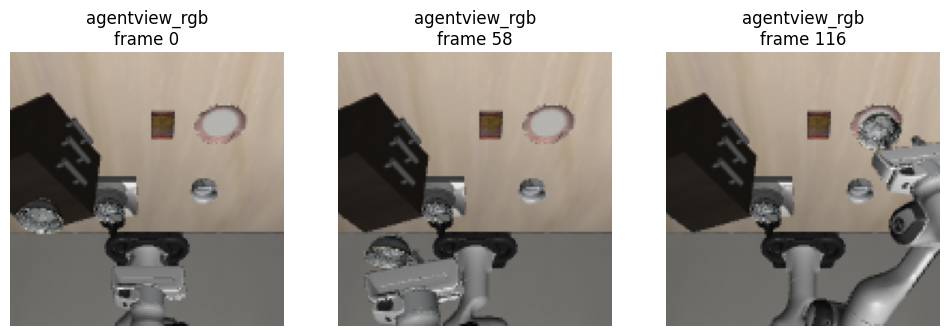

  - eye_in_hand_rgb: shape=(117, 128, 128, 3) dtype=uint8


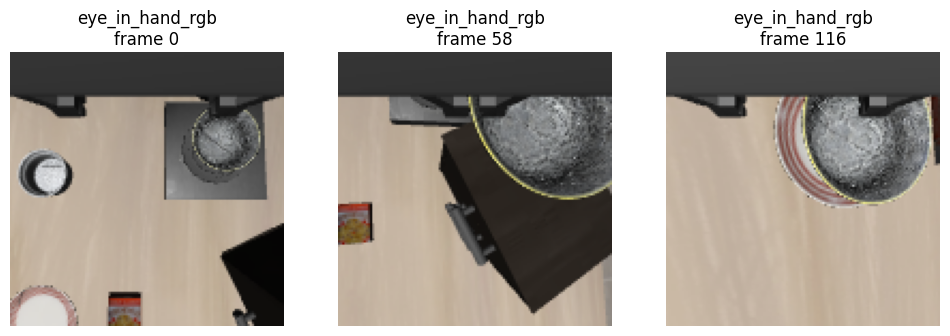

pick_up_the_black_bowl_on_the_cookie_box_and_place_it_on_the_plate_demo.hdf5
demo: demo_7
  - agentview_rgb: shape=(95, 128, 128, 3) dtype=uint8


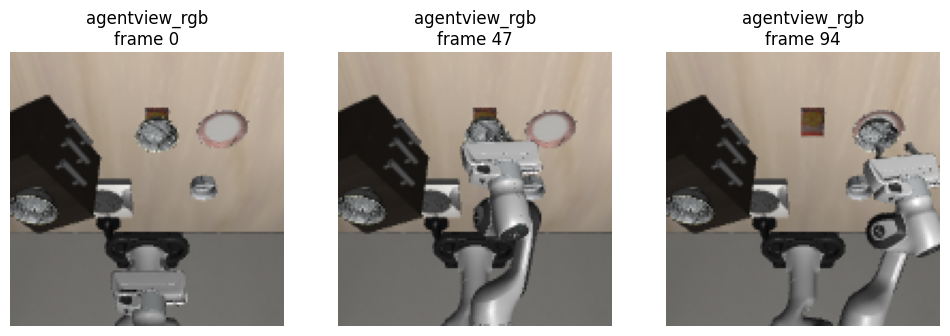

  - eye_in_hand_rgb: shape=(95, 128, 128, 3) dtype=uint8


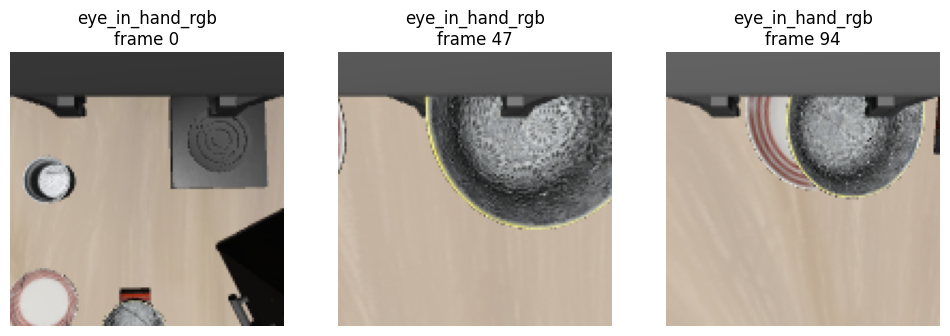

In [22]:
def show_frames(rgb, title):
    T = rgb.shape[0]
    idxs = [0, T//2, T-1] if T >= 3 else list(range(T))
    idxs = list(dict.fromkeys(idxs))

    plt.figure(figsize=(4*len(idxs), 4))
    for i, t in enumerate(idxs):
        plt.subplot(1, len(idxs), i+1)
        plt.imshow(rgb[t])
        plt.axis("off")
        plt.title(f"{title}\nframe {t}")
    plt.show()

def visualize_sample(task_path: Path, demo_id: str):
    with h5py.File(task_path, "r") as f:
        demo = f["data"][demo_id]
        obs = demo["obs"]

        print("="*110)
        print(task_path.name)
        print("demo:", demo_id)

        for cam in ["agentview_rgb", "eye_in_hand_rgb"]:
            if cam not in obs:
                print(f"  - {cam}: not present")
                continue
            rgb = np.array(obs[cam])
            if rgb.ndim == 4 and rgb.shape[-1] == 4:
                rgb = rgb[..., :3]
            if rgb.ndim == 4 and rgb.shape[-1] == 1:
                rgb = np.repeat(rgb, 3, axis=-1)

            print(f"  - {cam}: shape={rgb.shape} dtype={rgb.dtype}")
            show_frames(rgb, cam)

# visualize up to K samples so the notebook doesn't explode
K = min(10, len(samples))
for task_path, demo_id in samples[:K]:
    visualize_sample(task_path, demo_id)
